Improting datafile and parsing the data

In [8]:
import csv                #importing library for *.csv files processing
from math import sqrt     #importing sqrt function from math library

timeline = []             #tuple to hold the global time in ms from 1st Jan 1970
acc_x = []                #acceleration on x-axis
acc_y = []                #acceleration on y-axis
acc_z = []                #acceleration on z-axis

with open("Data/running_pocket_1.csv") as datafile:     #opening given *.tsv file
    datareader = csv.reader(datafile, delimiter=",")                 #setting separation symbol as TAB
    for line in datareader:                                           #writing the data on prepeared lists: 
        try:
            timeline.append(float(line[0]))
            acc_x.append(float(line[1]))
            acc_y.append(float(line[2]))
            acc_z.append(float(line[3]))
        except(ValueError):
            pass

Processing of data to get the time (in milliseconds) in the first column, and total acceleration (in $m/s^2$) in the other

In [9]:
raw_time = [0.0]               #setting the global time beginning as 0.0
raw_acceleration = [0.0]       #setting the initial acceleration as 0.0
acceleration_x = [0.0]
acceleration_y = [0.0]
acceleration_z = [0.0]
for i in range(1,len(timeline)):
    raw_time.append( timeline[i] )         #shifting the global time 
    raw_acceleration.append(sqrt(acc_x[i]**2 + acc_y[i]**2 + acc_z[i]**2))     #appending of the acceleration module
    acceleration_x.append(acc_x[i])
    acceleration_y.append(acc_y[i])
    acceleration_z.append(acc_z[i])

Showing the data-sample plot

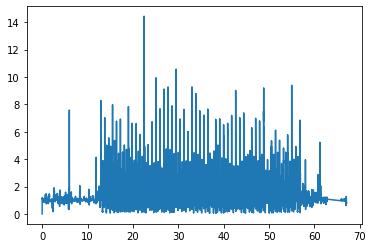

In [11]:
import matplotlib.pyplot as plt                      # importing the library for graphs drawing
fig = plt.plot(raw_time,raw_acceleration)  # plotting the graph for the initial data controling
                                                     # WARNING! sometimes data has gaps, 
                                                     # so you should control this

Sampling function (divides all data set on the sequences with equal *time_length*)

In [4]:
def Sampling(initial_data, time_length):
# Function divides the initial data lists for the pieces with given time_length
# EXAMPLE: s_data = Sampling([time[0:25000],acceleration[0:25000]], 1000.0)
    
    local_time = 0.0    #local time variable
    
    export_t = [[]]     #list for lists of exported sequences of local time
    export_a = [[]]     #list for lists of exported sequences of corresponding accelerations
    
    j=0                 #iterator for the number of sequence
    
    for i in range(1,len(initial_data[0])):                     
        local_time += initial_data[0][i] - initial_data[0][i-1]    #iterating the local time
        
        export_t[j].append(local_time)                             #exporting the local time
        export_a[j].append(initial_data[1][i])                     #exporting the acceleration
        
        if(local_time > time_length):                              #if local-time more then time length
            local_time = 0.0                                       #local_time is setting up to zero
            j+=1                                                   #iterating the number of sequence 
            export_t.append([])                 #making new sequence for time
            export_a.append([])                 #making new sequence for acceleration
            
    return([export_t,export_a])                 #final export

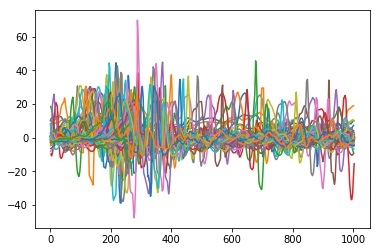

In [5]:
s_data = Sampling([raw_time[0:25000],acceleration_z[0:25000]], 1000.0)   #sampling the initial data
for i in range(len(s_data[0])):                                    
    fig = plt.plot(s_data[0][i],s_data[1][i])                      #plotting the figure

Normalization of the data to get sequences with equidistant time points

In [6]:
def normalization(times,acc):
#function normalises the data-set (interpolates skipped itme-points)
#EXAMPLE: ns_data = normalization(s_data[0][3],s_data[1][3])
    
    #Define the minimal step by the time 
    dt = times[1] - times[0]    
    for i in range(1,len(times)):
        if(dt>times[i]-times[i-1]):
            dt = times[i] - times[i-1]
    
    export_t = [times[0]]                     #list for the time sequences
    export_a = [acc[0]]                       #list for the acceleration sequences
    
    #updating the time and acceleration sequences
    for i in range(1,len(times)):
        if(times[i]-export_t[-1]==dt):
            export_t.append(times[i])
            export_a.append(acc[i])
        else:
            while(times[i]-export_t[-1]!=dt):
                export_t.append(export_t[-1]+dt)
                export_a.append(acc[i])
                
    return([export_t,export_a])
    

Normalization of sequence

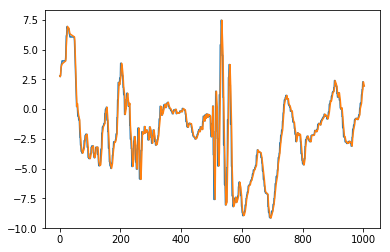

In [7]:
#controlling of the data normalization
ns_data = normalization(s_data[0][3],s_data[1][3])
fig = plt.plot(ns_data[0],ns_data[1])
fig = plt.plot(s_data[0][3],s_data[1][3])

In [8]:
import numpy as np

def GetFFT(sample):
    t = []
    for time in sample[0]:
        t.append(time/1000.0) # time vector
    Ts = 0.001
    y = sample[1]
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n*Ts
    frq = k/T # two sides frequency range
    frq = frq[range(int(n/2))] # one side frequency range
    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(int(n/2))]
    return([frq,abs(Y)])


Getting FFT Spectre and showing it on graphs

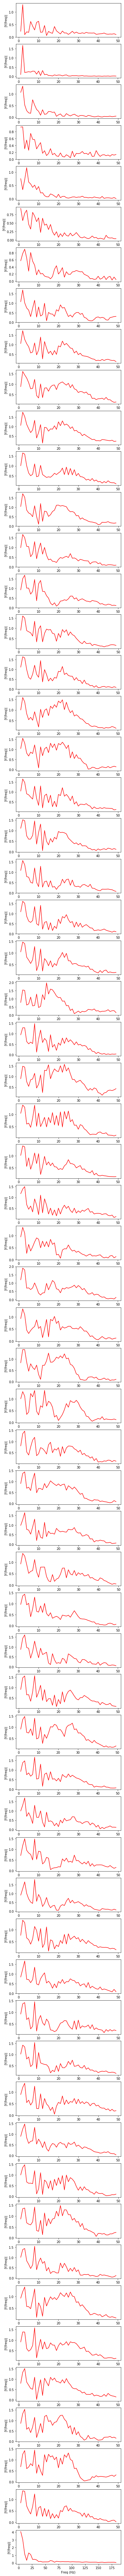

In [9]:
freq_data = []
accel_data = []

sample_len = 50

fig,ax = plt.subplots(len(s_data[0]), 1,figsize=(6, 150))
for i in range(len(s_data[0])):
    ns_data = normalization(s_data[0][i],s_data[1][i])
    [f,a] = GetFFT([ns_data[0],ns_data[1]])
    freq_data.append(f[1:sample_len])
    accel_data.append(a[1:sample_len])
    ax[i].plot(f[1:sample_len],a[1:sample_len],'r') # plotting the spectrum
    ax[i].set_xlabel('Freq (Hz)')
    ax[i].set_ylabel('|Y(freq)|')

In [10]:
mean_freq = []
mean_acc = []
for i in range(len(freq_data[0])):
    tempf = 0.0
    for j in range(len(freq_data)-1):
        tempf+=freq_data[j][i]
    tempa = 0.0
    for j in range(len(freq_data)-1):
        tempa+=accel_data[j][i]
    mean_freq.append(tempf/(len(freq_data)-1))
    mean_acc.append(tempa/(len(freq_data)-1))

Text(0.5, 1.0, 'Controlling of mean and signal values')

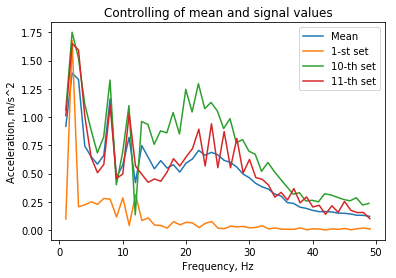

In [50]:
import pylab

pylab.plot(mean_freq, mean_acc,label="Mean")
pylab.plot(freq_data[1],accel_data[1], label = "1-st set")
pylab.plot(freq_data[10],accel_data[10], label = "10-th set")
pylab.plot(freq_data[11],accel_data[11], label = "11-th set")
pylab.legend(loc='upper right')

pylab.xlabel('Frequency, Hz')
pylab.ylabel('Acceleration, m/s^2')
pylab.title('Controlling of mean and signal values')

In [12]:
difference=[]
for i in range(len(freq_data)-1):
    difference.append(0.0)
    for j in range(len(freq_data[i])):
        difference[-1]+=(accel_data[i][j]-mean_acc[j])**2

Text(0.5, 0, 'Number of the sequence')

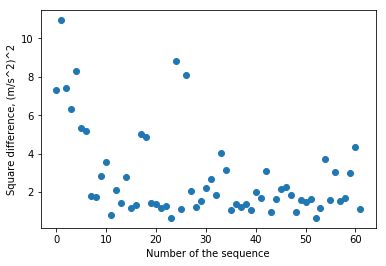

In [13]:
pylab.plot(difference,'o')
pylab.ylabel('Square difference, (m/s^2)^2')
pylab.xlabel('Number of the sequence')

In [14]:
def SimCos(x,y):
    a = 0.0
    b = 0.0
    c = 0.0
    for i in range(len(x)):
        a+=x[i]*y[i]
        b+=x[i]**2
        c+=y[i]**2
    return(sqrt(a/(sqrt(b)*sqrt(c))))

In [15]:
cos_sim=[]
for i in range(len(freq_data)-1):
    cos_sim.append(SimCos(accel_data[i],mean_acc))

Text(0.5, 0, 'Number of sequence')

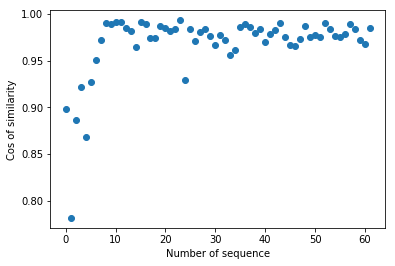

In [16]:
pylab.plot(cos_sim,'o')
pylab.ylabel("Cos of similarity")
pylab.xlabel("Number of sequence")

In [17]:
from pylab import *
import matplotlib.pyplot as plt

def make_mesh(f_min, f_max, N, f_data, a_data):
    number = range(N)
    frequency = linspace(f_min, f_max, N)
    X,Y = meshgrid(number, frequency)
    Z = []
    for i in range(N):
        Z.append([])
        for j in range(len(frequency)-1):
            Sum = 0
            num = 0
            for k in range(len(f_data[i])):
                if((f_data[i][k]>=frequency[j])&(f_data[i][k]<frequency[j+1])):
                    Sum += a_data[i][k]
                    num += 1
            if(num!=0):
                Z[-1].append(Sum/num)
            else:
                Z[-1].append(0.0)
    Z = np.array(Z)
    return([X,Y,Z])

[X,Y,Z] = make_mesh(1.0,50,50,freq_data,accel_data)


/home/cbapka/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


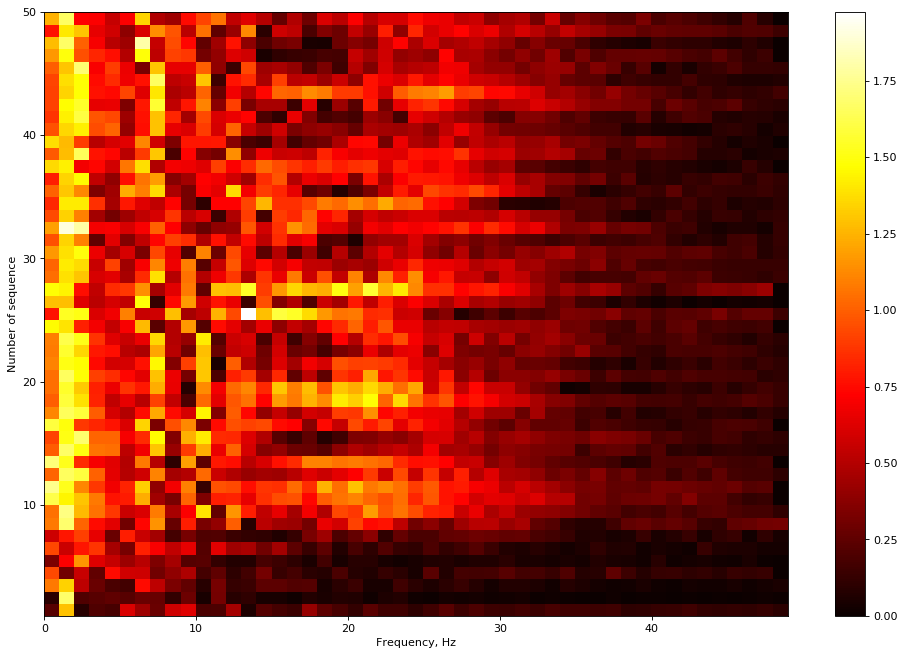

In [18]:
fig, ax = subplots(figsize=(15, 10), dpi= 80)

p = ax.pcolor(X, Y, Z, cmap=cm.hot, vmin=abs(Z).min())
cb = fig.colorbar(p)

plt.xlabel("Frequency, Hz")
plt.ylabel("Number of sequence")

fig.show()

Direct comparisment of the data-sets. Starting from the normalization of the initial ("long") data-set. 

In [26]:
[normalized_raw_time, normalized_raw_acc] = normalization(raw_time[1:25000],acceleration_z[1:25000])
[normalized_sample_time, normalized_sample_acc] = normalization(s_data[0][15],s_data[1][15])

Text(0, 0.5, 'z-acceleration, m/s^2')

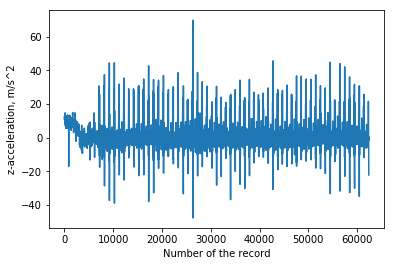

In [69]:
pylab.plot(normalized_raw_time,normalized_raw_acc)
pylab.xlabel("Number of the record")
pylab.ylabel("z-acceleration, m/s^2")

Text(0, 0.5, 'z-acceleration, m/s^2')

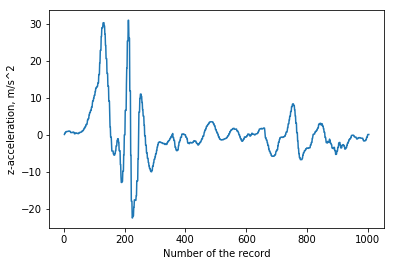

In [70]:
pylab.plot(normalized_sample_time, normalized_sample_acc)
pylab.xlabel("Number of the record")
pylab.ylabel("z-acceleration, m/s^2")

In [38]:
def SimCos_our(a,b):
    scal_mult = 0.0
    mod_a = 0.0
    mod_b = 0.0
    ans = 0.0
    if(len(a)==len(b)):
        for i in range(len(a)):
            scal_mult += a[i]*b[i]
            mod_a += a[i]**2
            mod_b += b[i]**2
        ans = scal_mult/(sqrt(mod_a)*sqrt(mod_b))
    else:
        ans = 0.0
    return(ans)       

0.5773502691896258

In [51]:
import warnings

s_cos = []
for i in range(0,50000):
    try:
        s_cos.append(SimCos_our(normalized_raw_acc[i:i+len(normalized_sample_acc)],normalized_sample_acc))
    except(Warning):
        pass

Text(0, 0.5, 'cos similarity')

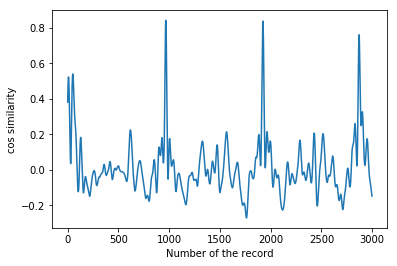

In [71]:
pylab.plot(s_cos[30000:33000])
pylab.xlabel("Number of the record")
pylab.ylabel("cos similarity")

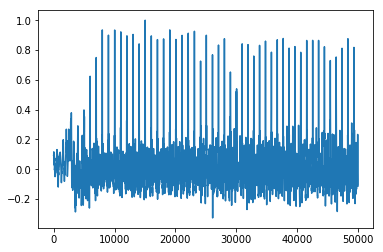

In [54]:
pylab.plot(s_cos)

Export of the reference data

In [66]:
file = open("export_reference.dat",'w')
for i in range(len(normalized_sample_acc)):
    file.write(str(i/1000.0)+"\t"+str(normalized_sample_acc[i])+"\n")
file.close()

Export of the main data

In [72]:
file = open("export_main.dat",'w')
for i in range(len(normalized_raw_acc)):
    file.write(str(i/1000.0)+"\t"+str(normalized_raw_acc[i])+"\n")
file.close()

Export of the cosine similarity 

In [73]:
file = open("export_sim.dat",'w')
for i in range(len(s_cos)):
    file.write(str(i/1000.0)+"\t"+str(s_cos[i])+"\n")
file.close()

Export of spectres

In [78]:
file = open("export_spect.dat",'w')
for i in range(len(mean_freq)):
    file.write(str(mean_freq[i])+"\t"+str(mean_acc[i])+"\n")
file.write("\n")

for i in range(len(mean_freq)):
    file.write(str(freq_data[1][i])+"\t"+str(accel_data[1][i])+"\n")
file.write("\n")

for i in range(len(mean_freq)):
    file.write(str(freq_data[10][i])+"\t"+str(accel_data[10][i])+"\n")
file.write("\n")

for i in range(len(mean_freq)):
    file.write(str(freq_data[20][i])+"\t"+str(accel_data[20][i])+"\n")
file.write("\n")

file.close()